# SMQTK Docker Bundle Example Usage and Demonstration

This notebook demonstrates how to use the prepared docker containers that provide the SMQTK nearest neighbor service from within a python application.


In addition to the packages needed to run jupyter notebooks, you will also need to have the following python packages installed:

 - docker-compose
 - matplotlib
 - numpy
 - pillow
 - requests


In addition, you will also need:

 - the latest version of docker installed and properly configured for your host system
 - a copy of the SMQTK source code
 - and a collection of images under a single directory in your host's local filesystem

In [55]:
!python -m pip install numpy matplotlib docker-compose pillow requests

    100% |████████████████████████████████| 4.6MB 121kB/s ta 0:00:011
    100% |████████████████████████████████| 12.8MB 110kB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 2.2MB/s a 0:00:01
    100% |████████████████████████████████| 3.5MB 371kB/s ta 0:00:01
  Using cached requests-2.18.1-py2.py3-none-any.whl
  Using cached cycler-0.10.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 61kB 3.5MB/s ta 0:00:011
  Using cached pytz-2017.2-py2.py3-none-any.whl
  Using cached pyparsing-2.2.0-py2.py3-none-any.whl
  Using cached ipaddress-1.0.18-py2-none-any.whl
  Using cached enum34-1.1.6-py2-none-any.whl
    100% |████████████████████████████████| 204kB 1.9MB/s ta 0:00:01
    100% |████████████████████████████████| 112kB 2.2MB/s ta 0:00:01
  Using cached chardet-3.0.4-py2.py3-none-any.whl
  Using cached urllib3-1.21.1-py2.py3-none-any.whl
  Using cached idna-2.5-py2.py3-none-any.whl
  Running setup.py bdist_wheel for subprocess32 ... done
  Stored in direc

## Set input variables

Only two variables need be adjusted for this demonstration; they are `path_to_smqtk_source` and `path_to_image_collection`, and you should change the code below so that they are set to the path to the SMQTK source code and the path to the directory containing the collection of images you will use as input to the nearest neighbor service, respectively.  The default code sets the SMQTK source code path to `$HOME/smqtk` and the image collection path to `$HOME/leedsbutterfly/images`.

In [56]:
import os
import os.path

################################################################################
############# Change these two variables to suite your application #############
################################################################################

path_to_smqtk_source = os.path.expanduser(os.path.join('~', 'smqtk'))

path_to_image_collection = os.path.expanduser(os.path.join('~',
                                                           'leedsbutterfly',
                                                           'images'))

################################################################################

os.chdir(os.path.join(path_to_smqtk_source, 'docker'))
print('current directory: ' + os.getcwd())
print('\nimage directory: ' +
      path_to_image_collection +
      '\n\n    contents:\n')
_, _, files = next(os.walk(path_to_image_collection))
counter = 0
for file in files:
    if file.startswith('.'):
        continue
        
    print('      ' + file)
    counter += 1
    
    if counter >= 10:
        print('\n      ...')
        break
        

current directory: /Users/opadron/smqtk/docker

image directory: /Users/opadron/leedsbutterfly/images

    contents:

      001_0001.jpg
      001_0002.jpg
      001_0003.jpg
      001_0004.jpg
      001_0005.jpg
      001_0006.jpg
      001_0007.jpg
      001_0008.jpg
      001_0009.jpg
      001_0010.jpg

      ...


## The run_command() function

Here, we define a python convenience function for portably running the docker commands we will need to start and stop the nearest neighbor service.  The command is written to automatically export the `IMAGE_DIR` environment variable to the location of the image collection you specified in the prior step.  Docker will need the information in this variable to provide the data therein to the isolated containers that will run the service.

In [57]:
from sys import stdout, stderr
import subprocess as sp

subprocess_environment = os.environ.copy()
subprocess_environment['IMAGE_DIR'] = path_to_image_collection

def run_command(command):
    P = sp.Popen(command,
                 bufsize=1,
                 universal_newlines=True,
                 stdout=sp.PIPE,
                 stderr=sp.PIPE,
                 env=subprocess_environment)

    reading_stdout = True
    reading_stderr = True
    exit_code = None

    while reading_stdout or reading_stderr or exit_code is None:
        if reading_stdout:
            data = P.stdout.read(128)
            if not data:
                reading_stdout = False
            else:
                stdout.write(data)

        if reading_stderr:
            data = P.stderr.read(128)
            if not data:
                reading_stderr = False
            else:
                stderr.write(data)

        if exit_code is None:
            exit_code = P.poll()
    
    if exit_code != 0:
        raise sp.CalledProcessError()
        
    return exit_code

## Start the docker containers that will provide the nearest neighbor service

In [59]:
run_command(['docker-compose', 'up', '-d'])

Creating network "docker_default" with the default driver
Creating smqtk-postgres ... 
Creating smqtk-postgres

Creating smqtk-postgres ... done
Creating docker_smqtk_1 ... 
Creating docker_smqtk_1

Creating docker_smqtk_1 ... done
Creating docker_wrapper_1 ... 
Creating docker_wrapper_1

Creating docker_wrapper_1 ... done


0

## Wait for the service to begin accepting connections

For an initial period of time, the nearest neighbor service will be busy processing and indexing the images provided in the image collection you specified.  During this time, the service will not be accepting connections.

Below is a python loop that will poll the service until it becomes available.  Note that there is a chance that the code below may "time out", especially if your host machine is slow or if the volume of image data you provided in your collection is especially large.  In this case, you could run the code block again until it returns successfully.  You might also want to adjust the values given to `num_attempts` and `poll_interval`.

If you have trouble connecting to the service at all, check to ensure that your docker environment is operating correctly.

In [60]:
from time import sleep
import requests
from sys import stdout

num_attempts = 10
poll_interval = 30.0
connection_successful = False
for attempt in range(num_attempts):
    stdout.write('connection attempt {}/{}: '.format(attempt + 1, num_attempts))
    stdout.flush()
    req = requests.get('http://localhost:12345/count')
    if req.status_code == 503: # downstream service is still preprocessing images
        print('busy')
        sleep(poll_interval)
    else:
        print('connected!')
        connection_successful = True
        break
        
print()
if connection_successful:
    print(req.json())
else:
    print((
        'Connection failed after {} attempt{}.  '
        'Check to make sure that all docker services '
        'are running properly'
    ).format(num_attempts, '' if num_attempts == 1 else 's'))

connection attempt 1/10: connected!

{'count': 832}


## Choose a query image from the web and view it

Now, that the service is up and running, we must choose a "query" image from the web.  Change the value of `query_url` to a url that refers directly to the image you would like to use from the web (try right-clicking an image and clicking on "Copy Image Address"). 

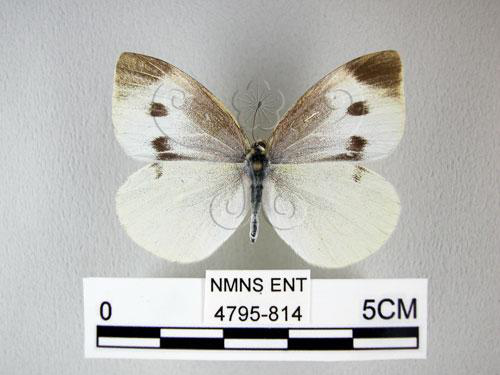

In [61]:
query_url = 'http://localhost:12345/image/b9de1f8af1093ecc1f49da847d3f1ce686f70c99'
req = requests.get(query_url)

from PIL import Image
from io import BytesIO
I = Image.open(BytesIO(req.content))
I

## Query the nearest neighbor service, proper

Now, we can use the value for `query_url` to query the nearest neighbor service and retrieve the results from that query.

In [52]:
req = requests.get('http://localhost:12345/nn/' + query_url)
result = req.json()

from pprint import pprint as pp
pp(result)

{'distances': [0.0,
               5994.130831161339,
               6671.898228829687,
               6696.481467936626,
               6893.179320254432,
               6947.799251718096,
               6968.659682373035,
               7035.8260701117415,
               7051.239141519131,
               7114.1123074948355],
 'message': 'descriptor computed',
 'neighbors': ['b9de1f8af1093ecc1f49da847d3f1ce686f70c99',
               'fa1f6c3f9c8ced3700ef3f26d496775c81c8ec40',
               'cd5d4d0e027a4c0a8470179fa7abe78f2b4e18b9',
               'c400e7d28f752f958921fe2d500043d9686c9523',
               'bd48a15d9e8a5b99420522a4692ce9b9d3bb505c',
               '9062e4c9d2ece77d7c242511ce2177788356f6b6',
               '0526cc0ef3d987a955a8a67a0754ca1371c65e69',
               'ee3f8b878aa9b3788e89fbc9db85e86eb1d462ae',
               'a2f8b853eab690c03c9ba539c9f9d9cc7684f74b',
               '22e03c9eef0b5cbd94ec22a56874490ac4918a44'],
 'reference_uri': 'http://wrapper:12345/image

## Access the query results and view the neighboring images

The two most important attributes in the provided JSON response are 'distances', which quantifies how similar that particular neighbor is to your query image; and 'neighbors', which provide references to the actual neighbor images, themselves.  The code below uses numpy and matplotlib to plot the neighboring images in order of greatest similarity.

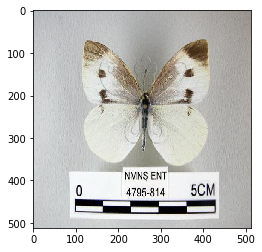

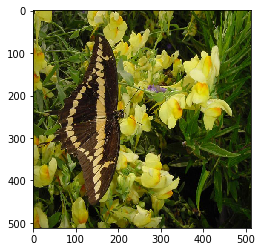

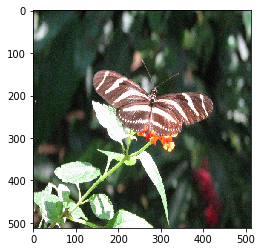

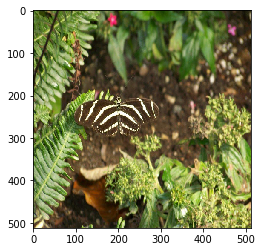

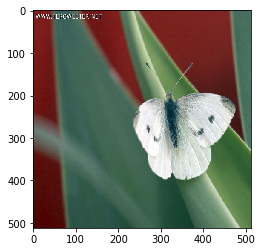

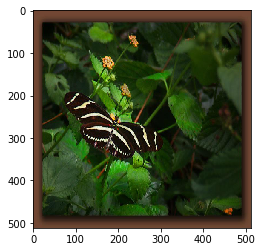

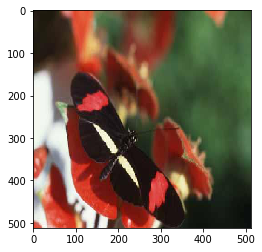

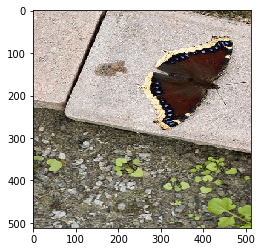

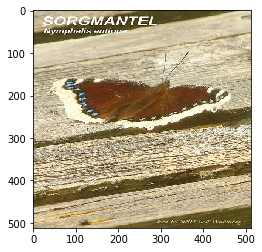

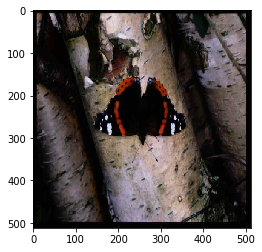

In [62]:
import numpy as np
from matplotlib import pyplot
from matplotlib.pyplot import imshow

figs = []

for index, neighbor in enumerate(result['neighbors']):
    req = requests.get('http://localhost:12345/image/' + neighbor)
    I = Image.open(BytesIO(req.content))
    fig = pyplot.figure()
    fig.gca().imshow(np.asarray(I.resize((512, 512))))
    figs.append(fig)
    
pyplot.show(figs)
for fig in figs:
    fig.clear()
del figs
    

## Terminate the docker containers running the nearest-neighbor service

With a query successfully performed and visualized, this demonstration is concluded.  Make sure that you shutdown and/or terminate the docker containers from above as part of your application's clean up stage.

In [63]:
run_command(['docker-compose', 'down'])

Stopping docker_wrapper_1 ... 
Stopping docker_smqtk_1 ... 
Stopping smqtk-postgres ... 

Stopping docker_wrapper_1 ... done

Stopping docker_smqtk_1 ... done

Stopping smqtk-postgres ... done
Removing docker_wrapper_1 ... 
Removing docker_smqtk_1 ... 
Removing smqtk-postgres ... 

Removing docker_smqtk_1 ... done

Removing docker_wrapper_1 ... done

Removing smqtk-postgres ... done
Removing network docker_default


0